# ML Classify News for [Business, Politics, General, Special Report] of BangkokPost  
- Collect data -> Scrape News from the internet URL = '
    - provide 
- Clean data & prepare data 
    - clean
    - stop_words
    - tokenize
    - corpus
    - TfifdVectorizer
    - CountVectorizer
- ML model (Compare Models) -> Cross Val Score with 10 k-folds
    - MultinomialNB
    - RandomForestClassifier
    - DecisionTreeClassifier
    - kNN
    - SVM
- Evaluate Model
    - Classification Report
        - Precision
        - Recall
        - F1-Score
    - Confusion Matrix 
        - TP
        - TN
        - FP
        - FN
    - ROC and Auc
    - Accuracy Score
    - Cross Validation Score
- Tuning Model 
    - GridSearchCV

# Part 1 Collect data : Collect 
- 1000 Business News:  https://www.bangkokpost.com/business/
- 1000 Politics News: https://www.bangkokpost.com/thailand/politics/
- 990 General News: https://www.bangkokpost.com/thailand/general


In [96]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
URLs = ['https://www.bangkokpost.com/business/',
        'https://www.bangkokpost.com/thailand/politics/',
        'https://www.bangkokpost.com/thailand/general',
       ]

newsList = list()

for URL in URLs:
    driver = webdriver.Firefox(executable_path = 'c:/users/Asus/geckodriver.exe')
    driver.get(URL)
    driver.maximize_window()
    sleep(3)
    currentPage = 1
    numClick = 100
    while currentPage <= numClick:
        body = driver.find_element_by_css_selector('body')
        body.send_keys(Keys.END)
        loadMore = driver.find_element_by_css_selector('a.btn-loadmore')
        driver.execute_script("arguments[0].click();",loadMore)
        sleep(2)
        currentPage += 1
    boxes = driver.find_elements_by_css_selector('div.listnews-row')
    for box in boxes:
        time = box.find_element_by_css_selector('div.listnews-datetime').text
        content = box.find_element_by_css_selector('p').text
        title = box.find_elements_by_css_selector('a')[1].text
        newsType = box.find_elements_by_css_selector('a')[0].text
        newsList.append([title,content,newsType,time])
    driver.close()

columns = ['Title','Content','newsType','time']
df = pd.DataFrame(newsList,columns=columns)
df

,Title,Content,newsType,time
0,"World's tourist hubs, 'ghost towns' for how long?",The coronavirus pandemic has brought the world...,BUSINESS,10:50
1,"US clamps down on China tech, blacklists CNOOC",WASHINGTON: The US government on Thursday ramp...,BUSINESS,08:45
2,Hoteliers hesitant to embrace ASQ scheme,Hoteliers are delaying their decisions on whet...,BUSINESS,06:43
3,FTI warns tyre AD will hit industry,The Federation of Thai Industries expects the ...,BUSINESS,05:51
4,Biden to unveil $1.9tn economic plan as US rec...,WASHINGTON: President-elect Joe Biden will unv...,BUSINESS,05:45
...,...,...,...,...
2985,Sedition case against Chaturon dismissed,The Criminal Court on Tuesday dismissed charge...,GENERAL,22 Dec 2020
2986,Pattaya New Year countdown cancelled,The Pattaya City municipality has cancelled th...,GENERAL,22 Dec 2020
2987,Ja New's mother cleared of lese majeste,The Criminal Court on Tuesday dismissed four-y...,GENERAL,22 Dec 2020
2988,Patient dies after motorist obstructs ambulance,A motorist who obstructed an ambulance rushing...,GENERAL,22 Dec 2020


In [97]:
df.to_csv('bangkokpostNews.csv',index=False)

In [98]:
df.isnull().sum()

Title       0
Content     0
newsType    0
time        0
dtype: int64

In [101]:
df.groupby(['newsType']).count()

,Title,Content,time
newsType,,,
BUSINESS,1000,1000,1000
GENERAL,990,990,990
POLITICS,1000,1000,1000


## Collect 1000 Business News, 990 General News and  1000 Politics News

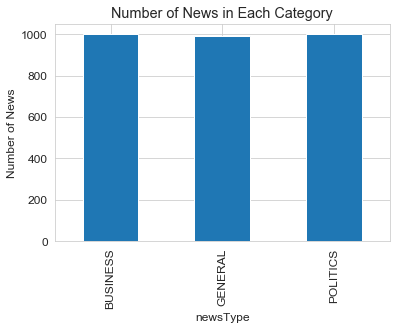

In [108]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size':12})
df.groupby(['newsType']).count()['Title'].plot.bar()
plt.title('Number of News in Each Category')
plt.ylabel('Number of News')
plt.show()

## Part 2: Feature extraction from text by using two methods which are: 
    - 1. TfidfVectorizer
    - 2. CountVectorizer
## Follow by doing Cross validation score with 10 K-Folds for choosing the best ML model
## Part 2.1 Start With TfidfVectorizer

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from time import time
# Put news into Corpus 
corpus = list()
for news in df.Content:
    corpus.append(news)
    
    
# Feature Extraction - TFIDF 
tfidfVect = TfidfVectorizer(stop_words = 'english')
matrix = tfidfVect.fit_transform(corpus)
matrix = matrix.toarray()
columns = tfidfVect.get_feature_names()
df_tfidfVect = pd.DataFrame(matrix,columns = columns)
df_tfidfVect

X = df_tfidfVect
y = df.newsType

# Compare Model by Cross Validation with 10-kfolds
models = [('MNB',MultinomialNB()),
          ('RndForest',RandomForestClassifier()),
          ('DecisionTree',DecisionTreeClassifier()),
          ('SVC-linear', SVC(kernel='linear')),
          ('SVC-rbf',SVC(kernel='rbf')),
          ('SVC-poly',SVC(kernel='poly')),
          ('kNN',KNeighborsClassifier(n_neighbors=5))]

model_cvs = dict()
for model in models:
    start_time = time()
    cvs = cross_val_score(model[1],X,y,cv=10)
    end_time = time()
    print('Model: {} takes {:.4} seconds for doing Cross Validation Score'.format(model[0],end_time-start_time))
    model_cvs[model[0]] = cvs
df_model_cvs = pd.DataFrame(model_cvs)
df_model_cvs

Model: MNB takes 1.441 seconds for doing Cross Validation Score
Model: RndForest takes 85.03 seconds for doing Cross Validation Score
Model: DecisionTree takes 61.58 seconds for doing Cross Validation Score
Model: SVC-linear takes 439.2 seconds for doing Cross Validation Score
Model: SVC-rbf takes 564.3 seconds for doing Cross Validation Score
Model: SVC-poly takes 605.5 seconds for doing Cross Validation Score
Model: kNN takes 125.0 seconds for doing Cross Validation Score


,MNB,RndForest,DecisionTree,SVC-linear,SVC-rbf,SVC-poly,kNN
0,0.859532,0.792642,0.732441,0.846154,0.809365,0.428094,0.799331
1,0.916388,0.876254,0.809365,0.899666,0.889632,0.494983,0.852843
2,0.923077,0.892977,0.842809,0.939799,0.916388,0.458194,0.856187
3,0.849498,0.819398,0.779264,0.869565,0.839465,0.515050,0.795987
4,0.933110,0.879599,0.816054,0.926421,0.939799,0.471572,0.866221
5,0.892977,0.852843,0.785953,0.892977,0.869565,0.478261,0.826087
6,0.892977,0.886288,0.842809,0.906355,0.886288,0.555184,0.836120
7,0.919732,0.852843,0.849498,0.889632,0.859532,0.581940,0.839465
8,0.916388,0.869565,0.792642,0.869565,0.869565,0.461538,0.876254
9,0.896321,0.859532,0.785953,0.899666,0.852843,0.414716,0.856187


In [133]:
print('================Mean CVS================')
print(df_model_cvs.mean())
print('================STD CVS=================')
print(df_model_cvs.std())

================Mean CVS================
MNB             0.900000
RndForest       0.858194
DecisionTree    0.803679
SVC-linear      0.893980
SVC-rbf         0.873244
SVC-poly        0.485953
kNN             0.840468
dtype: float64
================STD CVS=================
MNB             0.027600
RndForest       0.031223
DecisionTree    0.036161
SVC-linear      0.027627
SVC-rbf         0.037391
SVC-poly        0.052694
kNN             0.026851
dtype: float64


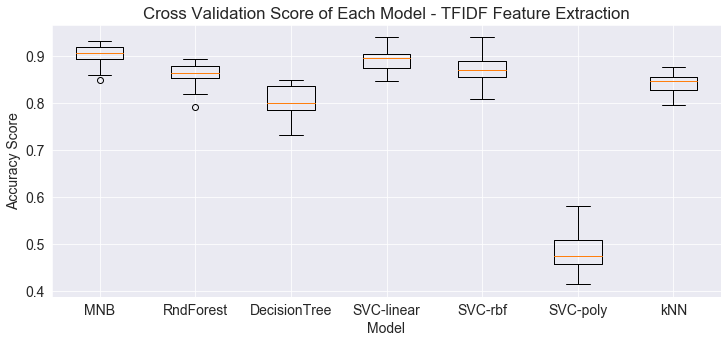

In [159]:
cvs_model = list()
for column in df_model_cvs.columns:
    cvs_model.append(df_model_cvs[column])
model_name = df_model_cvs.columns

plt.figure(figsize=(12,5))
plt.rcParams.update({'font.size':14})
sns.set_style('darkgrid')
ax = plt.subplot()
plt.boxplot(cvs_model)
ax.set_title('Cross Validation Score of Each Model - TFIDF Feature Extraction')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy Score')
ax.xaxis.set_ticklabels(model_name)

plt.show()

### The most appropriate model for doing text classification is MultinomialNB because
    - MNB has the highest mean of CVS compare to others 
    - MNB has the lowest standard deviation implying that the model is able to provide constant accuracy score 

# Part 2.2 Now try to use CountVectorizer

In [160]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from time import time
# Put news into Corpus 
corpus = list()
for news in df.Content:
    corpus.append(news)
#  Feature Extraction - CountVectorizer
countVect = CountVectorizer(stop_words = 'english')
matrix = countVect.fit_transform(corpus)
matrix = matrix.toarray()
columns = countVect.get_feature_names()
df_countVect = pd.DataFrame(matrix,columns = columns)
df_countVect

,00,000,02,065,10,100,105,106,108,109,...,zealand,zero,zhongshan,zodiac,zone,zones,zoo,zoological,zoom,zpot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## what is the most popular words appears in Bangkokpost news

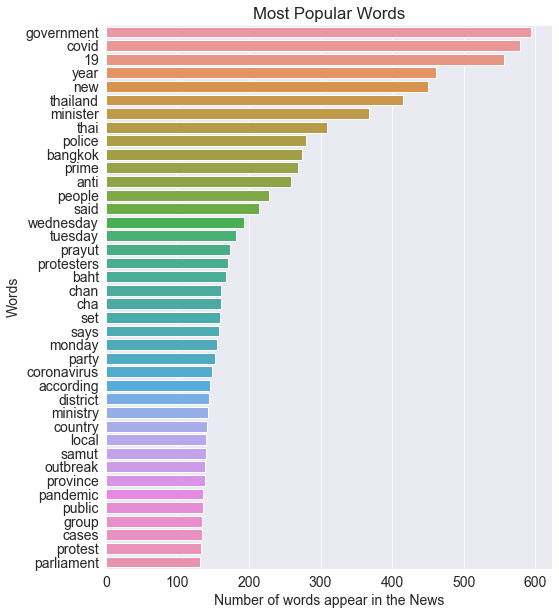

In [181]:
s1 = df_countVect.sum(axis=0,skipna=True).sort_values(ascending=False)[:40]
plt.figure(figsize=(8,10))
sns.barplot(s1.values,s1.index)
plt.title('Most Popular Words')
plt.xlabel('Number of words appear in the News')
plt.ylabel('Words')
plt.show()

In [182]:
X = df_countVect
y = df.newsType

# Compare Model by Cross Validation with 10-kfolds
models = [('MNB',MultinomialNB()),
          ('RndForest',RandomForestClassifier()),
          ('DecisionTree',DecisionTreeClassifier()),
          ('SVC-linear', SVC(kernel='linear')),
          ('SVC-rbf',SVC(kernel='rbf')),
          ('SVC-poly',SVC(kernel='poly')),
          ('kNN',KNeighborsClassifier(n_neighbors=5))]

model_cvs_countVect = dict()
for model in models:
    start_time = time()
    cvs = cross_val_score(model[1],X,y,cv=10)
    end_time = time()
    total_time_countVect = end_time - start_time
    print('Model: {} takes {:.4} seconds for doing Cross Validation Score'.format(model[0],total_time_countVect))
    model_cvs_countVect[model[0]] = cvs
df_model_cvs_countVect = pd.DataFrame(model_cvs_countVect)
df_model_cvs_countVect

Model: MNB takes 4.831 seconds for doing Cross Validation Score
Model: RndForest takes 74.62 seconds for doing Cross Validation Score
Model: DecisionTree takes 52.75 seconds for doing Cross Validation Score
Model: SVC-linear takes 298.5 seconds for doing Cross Validation Score
Model: SVC-rbf takes 575.3 seconds for doing Cross Validation Score
Model: SVC-poly takes 679.6 seconds for doing Cross Validation Score
Model: kNN takes 125.8 seconds for doing Cross Validation Score


,MNB,RndForest,DecisionTree,SVC-linear,SVC-rbf,SVC-poly,kNN
0,0.856187,0.782609,0.765886,0.802676,0.816054,0.695652,0.518395
1,0.916388,0.872910,0.789298,0.879599,0.869565,0.795987,0.595318
2,0.933110,0.879599,0.856187,0.919732,0.913043,0.795987,0.568562
3,0.866221,0.879599,0.819398,0.859532,0.846154,0.789298,0.488294
4,0.943144,0.879599,0.816054,0.929766,0.916388,0.792642,0.585284
5,0.899666,0.846154,0.775920,0.886288,0.869565,0.809365,0.581940
6,0.899666,0.869565,0.802676,0.896321,0.882943,0.795987,0.518395
7,0.926421,0.882943,0.782609,0.882943,0.879599,0.789298,0.575251
8,0.899666,0.906355,0.779264,0.879599,0.859532,0.749164,0.568562
9,0.909699,0.859532,0.832776,0.852843,0.882943,0.806020,0.618729


In [189]:
print('================Mean CVS================')
print(df_model_cvs_countVect.mean())
print('================STD CVS=================')
print(df_model_cvs_countVect.std())

================Mean CVS================
MNB             0.905017
RndForest       0.865886
DecisionTree    0.802007
SVC-linear      0.878930
SVC-rbf         0.873579
SVC-poly        0.781940
kNN             0.561873
dtype: float64
================STD CVS=================
MNB             0.027543
RndForest       0.033201
DecisionTree    0.028718
SVC-linear      0.035737
SVC-rbf         0.029613
SVC-poly        0.034426
kNN             0.040504
dtype: float64


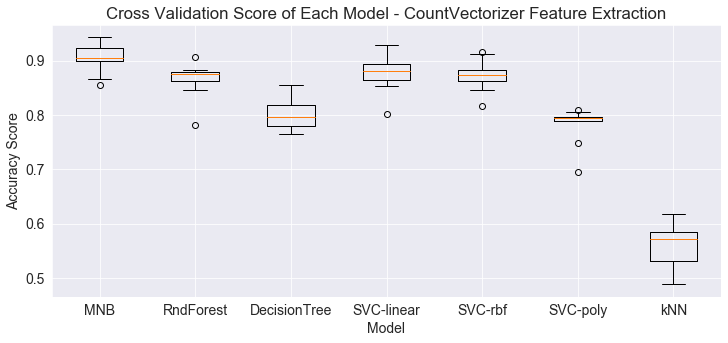

In [188]:
cvs_model = list()
for column in df_model_cvs_countVect.columns:
    cvs_model.append(df_model_cvs_countVect[column])
model_name = df_model_cvs.columns

plt.figure(figsize=(12,5))
plt.rcParams.update({'font.size':14})
sns.set_style('darkgrid')
ax = plt.subplot()
plt.boxplot(cvs_model)
ax.set_title('Cross Validation Score of Each Model - CountVectorizer Feature Extraction')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy Score')
ax.xaxis.set_ticklabels(model_name)
plt.show()

### Both CountVectorizer and TFIDF Feature Extraction give the same answer: MNB

# Part 3 Create Model -> Back Test -> Evaluate Model 
- 1. Create Model
    - As there are two steps for create model:
        - feature extraction
        - Create model
    - Therefore we will use pipeline
- 2. Back Test
- 3. Evaluate Model
    - 1. Classification Report
    - 2. Confusion Matrix
    - 3. collect accuracy score for 500 times and plots histogram

Classification Report: Multinomial NB - TFIDF Feature Extraction
              precision    recall  f1-score   support

    BUSINESS       0.97      0.92      0.94       316
    POLITICS       0.89      0.93      0.91       270
     GENERAL       0.96      0.97      0.96       311

    accuracy                           0.94       897
   macro avg       0.94      0.94      0.94       897
weighted avg       0.94      0.94      0.94       897



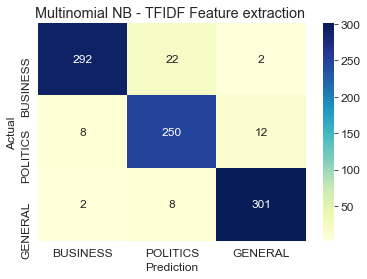

In [327]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Split data for train-test data
X = df.Content
y = df.newsType
target_names = df.newsType.unique()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# Create Pipeline doing two step -> 1) TFIDFVectorizer -> 2) MultinomialNB
pipe = Pipeline([('TFIDF',TfidfVectorizer()),
                 ('MNB', MultinomialNB())])

# training model
pipe.fit(x_train,y_train)

# Back test
y_pred = pipe.predict(x_test)

# Evaluate Model
print('Classification Report: Multinomial NB - TFIDF Feature Extraction')
print(classification_report(y_test,y_pred,target_names =target_names))
cm = confusion_matrix(y_test,y_pred)
ax = plt.subplot()
plt.rcParams.update({'font.size':12})
sns.heatmap(cm,annot=True, cmap='YlGnBu',fmt='d')
ax.set_title('Multinomial NB - TFIDF Feature extraction ')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.show()

Total time for collecting accuracy_score 500 times : 48.04 seconds
Mean of Accuracy Score for MNB - TFIDF : 0.942


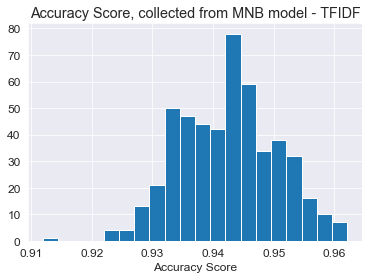

In [249]:
from time import time
acc_score_list = list()
X = df.Content
y = df.newsType
target_names = df.newsType.unique()
pipe = Pipeline([('TFIDF',TfidfVectorizer()),
                 ('MNB', MultinomialNB())])
st_time = time()
for i in range(500):
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
    # training model
    pipe.fit(x_train,y_train)
    # backtest
    y_pred = pipe.predict(x_test)
    # collect acc score
    acc_score = accuracy_score(y_test,y_pred)
    acc_score_list.append(acc_score)
end_time = time()
total_time = end_time - st_time
print('Total time for collecting accuracy_score 500 times : {:.4} seconds'.format(total_time))
print('Mean of Accuracy Score for MNB - TFIDF : {:.3}'.format(np.array(acc_score_list).mean()))
plt.hist(acc_score_list,bins=20)
plt.title('Accuracy Score, collected from MNB model - TFIDF')
plt.xlabel('Accuracy Score')
plt.show()

# Part 4:  Tuning model by GridSearchCV

In [269]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'fit_prior':[True,False]
             }
corpus = list()
for news in df.Content:
    corpus.append(news)
    
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(corpus)
tfidf_matrix = tfidf_matrix.toarray()
X = tfidf_matrix
y = df['newsType']
model = MultinomialNB()
gridSearch = GridSearchCV(model,param_grid,cv=10,scoring='accuracy',verbose=0)
gridSearch.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [270]:
print(gridSearch.best_score_)
print(gridSearch.best_params_)
print(gridSearch.best_estimator_)

0.9026755852842812
{'alpha': 0.4, 'fit_prior': False}
MultinomialNB(alpha=0.4, class_prior=None, fit_prior=False)


# After tuning model we knows the hyperparameters that can provide high accuracy score

# Part 5 Create real Model using parameter from Part4 (after tuning) and save it 

Classification Report: Multinomial NB - TFIDF Feature Extraction
              precision    recall  f1-score   support

    BUSINESS       0.95      0.93      0.94       322
    POLITICS       0.94      0.94      0.94       289
     GENERAL       0.96      0.99      0.97       286

    accuracy                           0.95       897
   macro avg       0.95      0.95      0.95       897
weighted avg       0.95      0.95      0.95       897



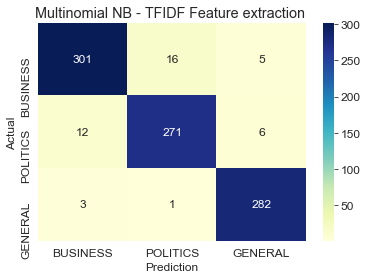

In [281]:
X = df.Content
y = df.newsType
target_names = df.newsType.unique()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

# Create Pipeline doing two step -> 1) TFIDFVectorizer -> 2) MultinomialNB
pipe = Pipeline([('TFIDF',TfidfVectorizer()),
                 ('MNB', MultinomialNB(alpha = 0.4,class_prior=None, fit_prior = False))])

# training model
pipe.fit(x_train,y_train)

# Back test
y_pred = pipe.predict(x_test)

# Evaluate Model
print('Classification Report: Multinomial NB - TFIDF Feature Extraction')
print(classification_report(y_test,y_pred,target_names =target_names))
cm = confusion_matrix(y_test,y_pred)
ax = plt.subplot()
plt.rcParams.update({'font.size':12})
sns.heatmap(cm,annot=True, cmap='YlGnBu',fmt='d')
ax.set_title('Multinomial NB - TFIDF Feature extraction ')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.show()

Total time for collecting accuracy_score 500 times : 48.76 seconds
Mean of Accuracy Score for MNB - TFIDF : 0.951


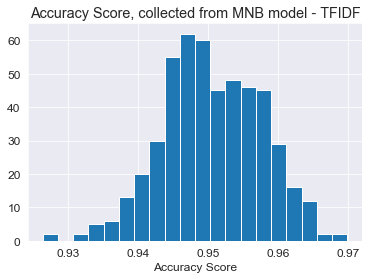

In [279]:
acc_score_list = list()
st_time = time()
for i in range(500):
    X = df.Content
    y = df.newsType
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
    # training model
    pipe.fit(x_train,y_train)
    # backtest
    y_pred = pipe.predict(x_test)
    # collect acc score
    acc_score = accuracy_score(y_test,y_pred)
    acc_score_list.append(acc_score)
end_time = time()
total_time = end_time - st_time
print('Total time for collecting accuracy_score 500 times : {:.4} seconds'.format(total_time))
print('Mean of Accuracy Score for MNB - TFIDF : {:.3}'.format(np.array(acc_score_list).mean()))
plt.hist(acc_score_list,bins=20)
plt.title('Accuracy Score, collected from MNB model - TFIDF')
plt.xlabel('Accuracy Score')
plt.show()

# Part6: Save MultinomialNB Machine Learning model for later use 

In [312]:
from sklearn.externals import joblib
joblib.dump(pipe,'Bangkokpost_newsClassifier_MultinomialNB.pkl')


['Bangkokpost_newsClassifier_MultinomialNB.pkl']

# Part7: Apply this Bangkokpost_newsClassifer_MultinomialNB.pkl to real data
- start with scrape news in three categories: 
    - Business
    - Politics
    - General

# Day1 : 1/16/2021 time 11.15 AM

In [318]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
URLs = ['https://www.bangkokpost.com/business/',
        'https://www.bangkokpost.com/thailand/politics/',
        'https://www.bangkokpost.com/thailand/general',
       ]

newsList_test = list()

for URL in URLs:
    driver = webdriver.Firefox(executable_path = 'c:/users/Asus/geckodriver.exe')
    driver.get(URL)
    driver.maximize_window()
    sleep(3)
    currentPage = 1
    numClick = 1
    while currentPage <= numClick:
        body = driver.find_element_by_css_selector('body')
        body.send_keys(Keys.END)
        loadMore = driver.find_element_by_css_selector('a.btn-loadmore')
        driver.execute_script("arguments[0].click();",loadMore)
        sleep(2)
        currentPage += 1
    boxes = driver.find_elements_by_css_selector('div.listnews-row')
    for box in boxes:
        time = box.find_element_by_css_selector('div.listnews-datetime').text
        content = box.find_element_by_css_selector('p').text
        title = box.find_elements_by_css_selector('a')[1].text
        newsType = box.find_elements_by_css_selector('a')[0].text
        newsList_test.append([title,content,newsType,time])
    driver.close()

columns = ['Title','Content','newsType','time']
df_test = pd.DataFrame(newsList_test,columns=columns)
df_test

,Title,Content,newsType,time
0,National Telecom urged to focus on infrastructure,The chief executive of a major mobile operator...,BUSINESS,10:33
1,Canadian firm pulls out of Carrefour takeover ...,PARIS: Canadian convenience store chain Couche...,BUSINESS,09:45
2,Panel approves airport expansion,A panel in charge of upgrading Suvarnabhumi ai...,BUSINESS,09:00
3,Nok Air: Six months liquidity remaining,Nok Air estimates it can sustain its business ...,BUSINESS,07:00
4,Finance Ministry mulls new round for co-payment,The Finance Ministry plans to add another regi...,BUSINESS,06:00
5,Pandemic steps to steer GDP outlook,Thailand's GDP growth projection of 3.2% for t...,BUSINESS,05:00
6,"Following US ban, Xiaomi unlikely to see sales...",The US ban on Xiaomi is unlikely to cause a sw...,BUSINESS,04:00
7,CRC unfazed by new Covid outbreak,"Central Retail Corporation (CRC), the SET-list...",BUSINESS,04:00
8,ITD seeks state help over Dawei issue,SET-listed Italian-Thai Development Plc (ITD) ...,BUSINESS,04:00
9,FTC Reaches Settlement With Flo Health Over Fe...,The Federal Trade Commission reached a settlem...,BUSINESS,04:00


# Look at the performance and find news that ML predicts incorrect

0.9166666666666666
              precision    recall  f1-score   support

    BUSINESS       0.90      0.95      0.93        20
    POLITICS       0.87      1.00      0.93        20
     GENERAL       1.00      0.80      0.89        20

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



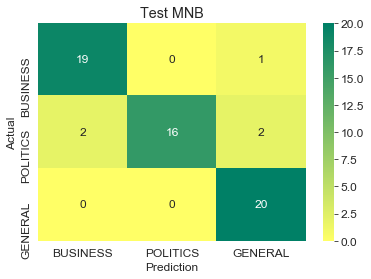

find news that ML predicts incorrect


,Title,Content,newsType,time,Prediction
8,ITD seeks state help over Dawei issue,SET-listed Italian-Thai Development Plc (ITD) ...,BUSINESS,04:00,POLITICS
42,Prayut to weigh in on legalising gambling,Prime Minister Prayut Chan-o-cha says he will ...,GENERAL,08:00,POLITICS
47,Thanathorn prosecution D-Day soon,Prosecutors will decide next month whether or ...,GENERAL,04:00,POLITICS
51,B15 fare for Gold Line from Saturday,Passengers on the 1.8-kilometre Gold Line mono...,GENERAL,15 Jan 2021,BUSINESS
56,B200m 'missing' from university aviation schoo...,The acting president of Nakhon Phanom Universi...,GENERAL,15 Jan 2021,BUSINESS


In [322]:
X_realTest = df_test.Content
y_realTest = df_test.newsType
y_pred_test = pipe.predict(X_realTest)
df_test['Prediction'] = y_pred_test
df_test

# Accuracy_Score 
print(accuracy_score(y_realTest,y_pred_test))
print(classification_report(y_realTest,y_pred_test,target_names))
ax = plt.subplot()
cm = confusion_matrix(y_realTest,y_pred_test)
sns.heatmap(cm,annot=True,cmap='summer_r',fmt='d')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_title('Test MNB')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.show()
print('find news that ML predicts incorrect')
df_test[df_test.newsType != df_test.Prediction]